In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
import itertools
from tqdm import tqdm_notebook
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image
from dataset import KneeGradingDataset
from augmentation import CenterCrop
from val_utils import validate_epoch
from copy import deepcopy
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import OneHotEncoder
from augmentation import CenterCrop
import cv2

from torchvision.models import resnet34

In [2]:
def load_picture16bit(fname):
    img = Image.open(fname)
    # We will use 8bit 
    img = np.array(img, dtype=float)
    img = np.uint8(255*(img/65535.))
    img = Image.fromarray(np.repeat(img[:, :, np.newaxis], 3, axis=2))
    
    return CenterCrop(300)(img)


def weigh_maps(weights, maps):
    maps = maps.squeeze()
    weights = weights.squeeze()

    res = Variable(torch.zeros(maps.size()[-2:]).cuda(), requires_grad=False)

    for i, w in enumerate(weights):
        res+=w*maps[i]

    return res

In [3]:


net = resnet34()
net.avgpool = nn.AvgPool2d(7,7)
net.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(512,5))

# Network
net = nn.DataParallel(net)
net.load_state_dict(torch.load('../snapshots_knee_grading_resnet/2017_10_17_13_10_14/epoch_12.pth'))
net.cuda()



mean_vector, std_vector = np.load(os.path.join('../snapshots_knee_grading_resnet/mean_std.npy'))
normTransform = transforms.Normalize(mean_vector, std_vector)

scale_tensor_transform = transforms.Compose([
        CenterCrop(300),
        transforms.Scale(224),
        transforms.ToTensor(),
        lambda x: x.float(),
        normTransform
    ])


test_files = os.listdir('../../KL_data/test/')
val_ds = KneeGradingDataset('../../KL_data/', 
                            test_files, 
                            transform=scale_tensor_transform,
                            stage='test')

val_loader = data.DataLoader(val_ds, batch_size=64, num_workers=10)


In [4]:
val_loss, probs, truth, names = validate_epoch(net, val_loader, F.cross_entropy)

Processing: 100%|█████████████████████████████████████████| 94/94 [00:19<00:00,  7.89it/s]


In [5]:
preds = probs.argmax(1)
# Validation metrics
cm = confusion_matrix(truth, preds)
kappa = np.round(cohen_kappa_score(truth, preds, weights="quadratic"),4)
acc = np.round(np.mean(cm.diagonal().astype(float)/cm.sum(axis=1)),4)
mse = np.round(mean_squared_error(truth, preds), 4)

fpr1, tpr1, _ = roc_curve(truth>1, probs[:,2:].sum(1))
auc = np.round(roc_auc_score(truth>1, probs[:,2:].sum(1)),4)


loss=np.round(log_loss(truth, probs),4)

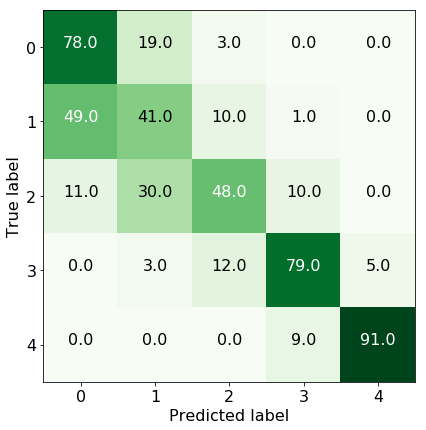

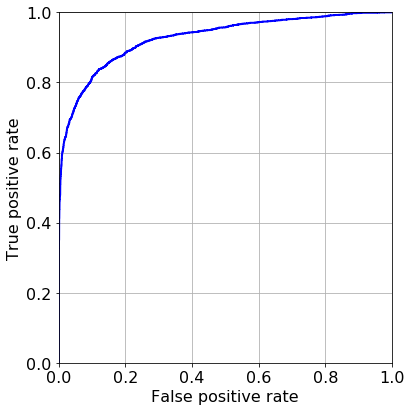

Kappa: 0.8256
Avg. class accuracy 0.6749
MSE 0.5072
AUC 0.9275
Cross-entropy: 0.8322


In [6]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,6))
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens, resample=False)
classes = ['No OA', 'Doubtful OA', 'Early OA','Mild OA','End-stage']
#plt.colorbar()
tick_marks = np.arange(len(classes))

#plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j]*100,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('conf_rnet.jpg', bbox_inches='tight', dpi=350, pad_inches = 0)
Image.open('conf_rnet.jpg').convert('RGB').save('conf_rnet.jpg', format='JPEG', subsampling=0, quality=100)
plt.show()

matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label='Own'.format(preds.shape[0]),lw=2, c='b')
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('ROC_AUC_test_rnet.jpg', bbox_inches='tight', dpi=300, pad_inches = 0)
Image.open('ROC_AUC_test_rnet.jpg').convert('RGB').save('ROC_AUC_test_rnet.jpg', format='JPEG', subsampling=0, quality=100)
plt.show()

print('Kappa:', kappa)
print('Avg. class accuracy', acc)
print('MSE', mse)
print('AUC',auc)
print('Cross-entropy:', loss)

In [7]:
# Producing the GradCAM output using the equations provided in the article
def gradcam_resnet(fname):
    img = load_picture16bit(fname)
    inp = scale_tensor_transform(img).view(1,3,224,224)
    net.train(False);
    net.zero_grad()

    features = nn.Sequential(net.module.conv1,
                             net.module.bn1,
                             net.module.relu,
                             net.module.maxpool,
                             net.module.layer1,
                             net.module.layer2,
                             net.module.layer3,
                             net.module.layer4)


    maps = features(Variable(inp.cuda()))
    maps_avg = F.avg_pool2d(maps,7).view(1, 512)

    grads = []
    maps_avg.register_hook(lambda x: grads.append(x));

    out = net.module.fc(maps_avg)


    ohe = OneHotEncoder(sparse=False, n_values=5)
    index = np.argmax(out.cpu().data.numpy(), axis=1).reshape(-1, 1)
    out.backward(torch.from_numpy(ohe.fit_transform(index)).float().cuda())

    heatmap = cv2.resize(F.relu(weigh_maps(grads[0], maps)).data.cpu().numpy(), (300, 300), cv2.INTER_CUBIC)
    
    probs = F.softmax(out).cpu().data[0].numpy()
    
    
    
    return img, heatmap, probs

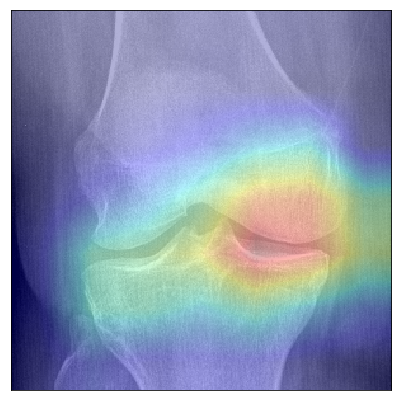

In [8]:
img, heatmap, probs = gradcam_resnet('../../KL_data/test/35_2_L_1_1_1_1_0_0.png')
plt.figure(figsize=(7,7))
plt.imshow(np.array(img), cmap=plt.cm.Greys_r)
plt.imshow(heatmap, cmap=plt.cm.jet, alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
if not os.path.isdir('../probs_resnet'):
    os.mkdir('../heatmaps_resnet')
    os.mkdir('../probs_resnet')
pbar = tqdm_notebook(total=len(test_files))
for fname in test_files:
    img, heatmap, probs = gradcam_resnet('../../KL_data/test/'+fname)
    plt.figure(figsize=(7,7))
    plt.imshow(np.array(img), cmap=plt.cm.Greys_r)
    plt.imshow(heatmap, cmap=plt.cm.jet, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('../heatmaps_resnet/'+fname, bbox_inches='tight', dpi=300, pad_inches = 0)
    plt.close()

    
    plt.figure(figsize=(7,1))

    for kl in range(5):
        plt.text(kl-0.2, 0.35, "%.2f" % np.round(probs[kl],2), fontsize=15)
    plt.bar(np.array([0, 1, 2, 3, 4]),probs, color='red',align='center',tick_label=['KL0','KL1','KL2','KL3','KL4'],alpha=0.3)
    plt.ylim(0,1)
    plt.yticks([])
    plt.savefig('../probs_resnet/'+fname, bbox_inches='tight', dpi=300, pad_inches = 0)
    plt.close()
    pbar.update(1)
pbar.close()

1